In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import multiprocessing as mp
from pathos.multiprocessing import ProcessingPool as Pool
import matplotlib.pyplot as plt
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from unidecode import unidecode
import time
import json
from glob import glob
import gc
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
stop_words = pd.read_csv('../word2vec/input/stop_words.txt', names=['words']).words
stop_words = dict(zip(stop_words,stop_words))
def remove_stop_words(sentence, stop_words=stop_words):
    words = []
    if type(sentence) != list:
        return []
    for word in sentence:
        if not stop_words.get(word):
            words.append(word)
    return words

In [3]:
def process_text(sentences):
    sentences = sentences.str.findall(r'[a-z]+')
    sentences = sentences.apply(remove_stop_words)
    return sentences

In [4]:
def parallelize_dataframe(df, func, num_partitions = mp.cpu_count(), num_cores = mp.cpu_count()):
    df_split = np.array_split(df, num_partitions, axis=0)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    pool.clear()
    return df

In [5]:
def join_files(files):
    tudo = ''
    for i, f in enumerate(files):
        with open(f) as file:
            t = pd.read_csv(file)
            if i == 0:
                tudo = t
            else:
                tudo = pd.concat([tudo, t], axis=0)
    return tudo

In [6]:
def get_words_freq(sentences, limit=0, ngram=1, sort=False):
    import operator
    vec = CountVectorizer(ngram_range=(ngram, ngram)).fit(sentences)
    bag_of_words = vec.fit_transform(sentences)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = { word: int(sum_words[0, idx]) for word, idx in     
                  vec.vocabulary_.items() } 
    if sort:
        words_freq = sorted(words_freq.items(), key=operator.itemgetter(1), reverse=True)
    if limit and limit > 0:
        words_freq = words_freq[:limit]
    return dict(words_freq)

In [7]:
def check_duplicates(files, columns=['id']):
    total = 0
    duplicados = 0
    for f in files:
        data = pd.read_csv(f, usecols=columns)
        iTotal = data.shape[0]
        total += iTotal
        data = data.drop_duplicates()
        duplicados += (iTotal - data.shape[0])
    return total, duplicados    

In [8]:
def check_null(files):
    result = pd.DataFrame()
    names = []
    for f in files:
        data = pd.read_csv(f)
        t = pd.DataFrame(data.isnull().sum(axis = 0))
        t = t.transpose()
        result = pd.concat([result,t])
        names.append(os.path.basename(f)[:-4])
    result.index = names
    return result

In [9]:
def describe(files, columns=['data', 'empresa', 'titulo', 'categoria',
       'tipo_problema', 'produto', 'estado', 'cidade']):
    result = pd.DataFrame()
    resumo = {c:pd.DataFrame() for c in columns}
    for f in files:
        data = pd.read_csv(f, usecols=columns)
        data.fillna('Não informada(o)', inplace=True)
        for c in columns:
            if c == 'titulo':
                # Normalização de input do usuário
                data[c] = data[c].apply(lambda w: unidecode(str(w).title()))
            elif c == 'data':
                data[c] = pd.to_datetime(df[c]).dt.date
            agg = data.groupby(c).agg(
                quantidade=('empresa','count')
            )
            resumo[c] = pd.concat([resumo[c],agg],axis=1)
    for k in resumo:
        resumo[k] = pd.DataFrame(resumo[k].sum(axis=1).sort_values(ascending=False), columns=['quantidade']) 
        resumo[k].index.name = k
    return resumo

# Análise de Dados

## 1. Reclame Aqui

In [54]:
# Lista de arquivos
files = [f for f in glob('../data_extraction/csv/reclame_aqui/*.csv')]
## Tentar realizar o join desses arquivos pode resultar em problemas de memória

### Registros vazios

In [10]:
df = check_null(files)

In [11]:
df.groupby('id').sum()

,data,empresa,titulo,review,reply1,reply2,reply3,reply4,reply5,interacoes,categoria,tipo_problema,outros_problemas,produto,estado,cidade
id,,,,,,,,,,,,,,,,
0,0,0,1,0,82202,513632,925579,1019779,1049581,0,1067596,1067717,907770,1067741,5,5


In [43]:
total, duplicados = get_duplicates(files)

### Quantidade de reclamações

In [44]:
total

1068254

### Registros duplicados

In [45]:
duplidados

0

In [ ]:
resumo = describe(files)

### Top 10 empresas mais reclamadas

In [15]:
resumo['empresa'].head(10)

,quantidade
empresa,
Banco do Brasil,99992.0
Banco Itaú,99977.0
Banco Bradesco,99961.0
Banco Santander,99955.0
Banco Cetelem,85412.0
Caixa Econômica Federal,83908.0
Santander Cartões,71316.0
Cielo,62263.0
Bradesco Seguros,33804.0


### Top 10 títulos das reclamações

In [16]:
resumo['titulo'].head(10)

,quantidade
titulo,
Cobranca Indevida,32545.0
Portabilidade,5145.0
Cartao De Credito,3022.0
Juros Abusivos,2649.0
Propaganda Enganosa,2635.0
Pessimo Atendimento,2485.0
Cancelamento,2242.0
Cobranca,2008.0
Descaso,1788.0


### Top 5 categorias mais reclamadas

In [65]:
resumo['categoria'].head(5)

,quantidade
categoria,
Não informada(o),1067596.0
Cartões de Crédito,154.0
Bancos,129.0
Seguradoras,67.0
Não encontrei meu problema,56.0


### Top 5 problemas mais relatados

In [66]:
resumo['tipo_problema'].head(5)

,quantidade
tipo_problema,
Não informada(o),1067717.0
Outro problema,100.0
Cobrança indevida,70.0
Mau Atendimento,20.0
Cobrança indevida de tarifas,16.0


### Top 5 produdos mais reclamados

In [67]:
resumo['produto'].head(5)

,quantidade
produto,
Não informada(o),1067741.0
Cartão de crédito,121.0
Outro Tipo de produto/Serviço,97.0
Problemas Gerais,46.0
Conta,42.0


### Top 5 registros por Estado

In [68]:
resumo['estado'].head(5)

,quantidade
estado,
SP,459963.0
RJ,133699.0
MG,100362.0
PR,48963.0
BA,46359.0


### Top 5 registros por cidade

In [69]:
resumo['cidade'].head(5)

,quantidade
cidade,
São Paulo,207006.0
Rio de Janeiro,76980.0
Belo Horizonte,32008.0
Brasília,24774.0
Salvador,21299.0


### Reclamações ao longo do tempo

In [148]:
df = resumo['data'].reset_index()

In [149]:
df['anos'] = df.data.apply(lambda w: str(w).split('-')[0])
df['mes'] = df.data.apply(lambda w: str(w).split('-')[1])
df['dia'] = df.data.apply(lambda w: str(w).split('-')[2])

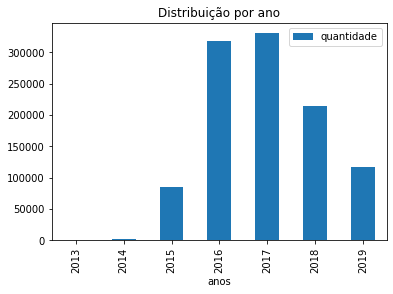

In [106]:
# Distribuição por ano
_ = df.groupby('anos')['anos','quantidade'].sum().plot(kind='bar', title='Distribuição por ano')

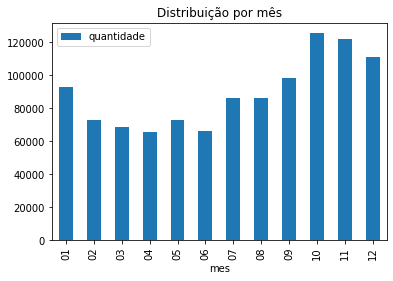

In [107]:
# Distribuição por mês
_ = df.groupby('mes')['mes','quantidade'].sum().plot(kind='bar', title='Distribuição por mês')

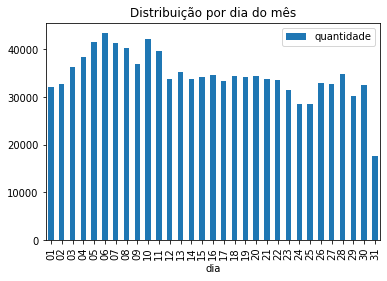

In [104]:
# Distribuição por dia do mês
_ = df.groupby('dia')['dia','quantidade'].sum().plot(kind='bar', title='Distribuição por dia do mês')

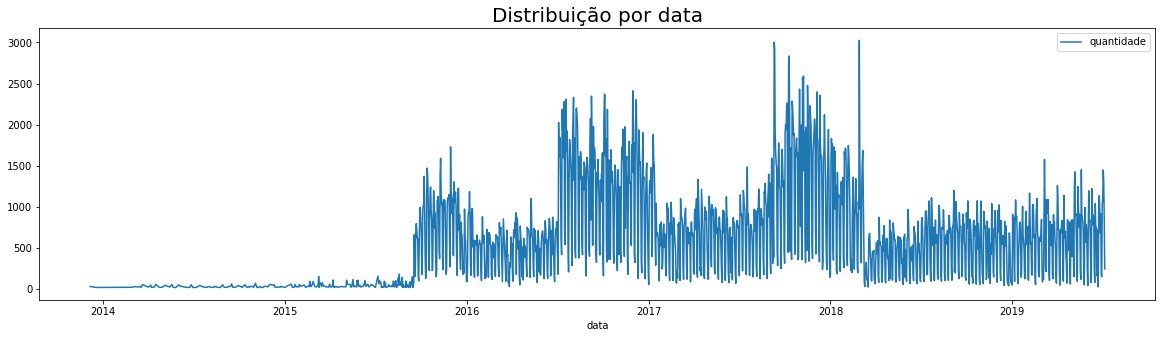

In [154]:
#### Distribuição data
df = df.sort_values(by='data')[['data','quantidade']]
_ = df.plot(x='data', y='quantidade', figsize=(20,5), kind='line')
_ = _.set_title('Distribuição por data', fontsize=20)

## 2. Lojas de aplicativos do Google e da Apple

In [26]:
# Arquivos ainda não pré-processados
files = [f for f in glob('../data_extraction/csv/*/*.csv')]

### Registros vazios

In [57]:
df = check_null(files)

In [58]:
df.groupby('id').sum()

,language,application_id,version,date,rating,title,review,body_length,author,sort_score,country,vote_count,vote_sum,is_edited,response
id,,,,,,,,,,,,,,,
0,0.0,0,54054.0,0,0,540274,22,0,0,397029,0.0,0.0,0.0,0.0,48306.0


In [59]:
total, duplicados = get_duplicates(files)

### Quantidade de reviews

In [60]:
total

639673

### Registros duplicados

In [61]:
duplicados

14656

In [10]:
# Arquivos já pré-processados
files = [f for f in glob('../word2vec/input/comentarios/*.csv') if 'android.csv' in f or 'ios.csv' in f]
df = join_files(files)

In [97]:
df.shape

(152259, 1)

In [98]:
df.review.str.len().describe()

count    152259.000000
mean        110.141200
std         110.175405
min           5.000000
25%          38.000000
50%          75.000000
75%         145.000000
max        4868.000000
Name: review, dtype: float64

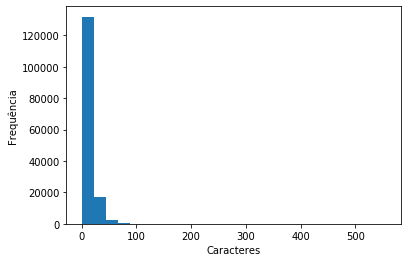

In [104]:
hist = plt.hist(df.review.str.len(), bins=25)
plt.xlabel('Caracteres')
plt.ylabel('Frequência')
plt.show()

In [100]:
df['review'] = parallelize_dataframe(df.review, process_text)

In [101]:
df.review.str.len().describe()

count    152259.000000
mean         11.811052
std          11.668705
min           0.000000
25%           4.000000
50%           8.000000
75%          16.000000
max         556.000000
Name: review, dtype: float64

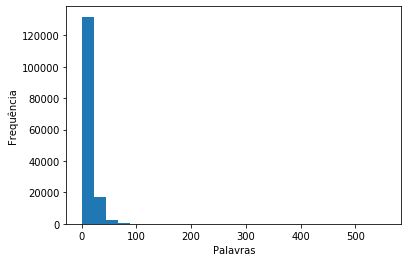

In [103]:
hist = plt.hist(df.review.str.len(), bins=25)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.show()

In [ ]:
df = df.dropna()
df = df[df.review.str.len() > 0]
df.review = df.review.str.join(' ')

In [12]:
sentences = df.review

In [13]:
freqs = get_words_freq(sentences)

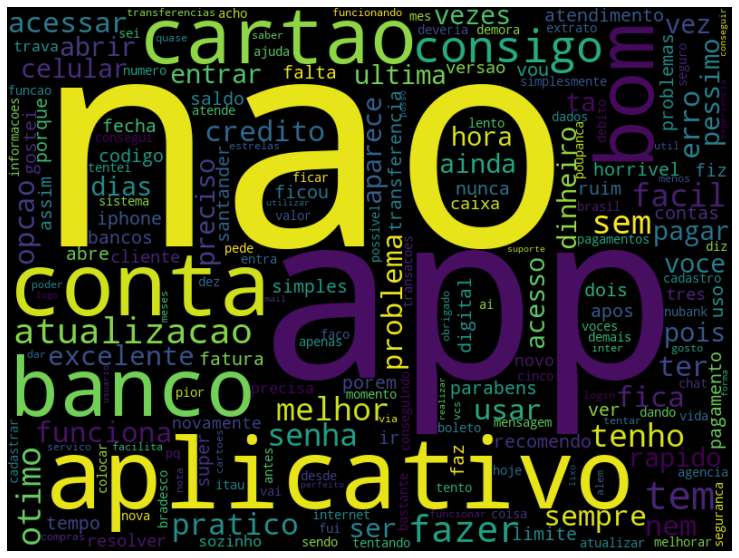

In [14]:
wordcloud = WordCloud(width=800, height=600).generate_from_frequencies(frequencies=freqs)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
bigrams = get_words_freq(sentences, 30, 2, True)

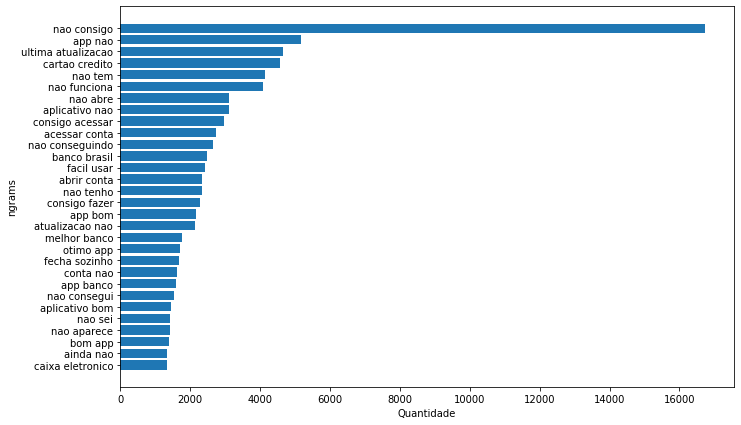

In [16]:
plt.figure(figsize=(11,7))
plt.barh(list(bigrams.keys()), bigrams.values(), align='center')
plt.xlabel('Quantidade')
plt.ylabel('ngrams')
plt.gca().invert_yaxis()

In [17]:
trigrams = get_words_freq(sentences, 30, 3, True)

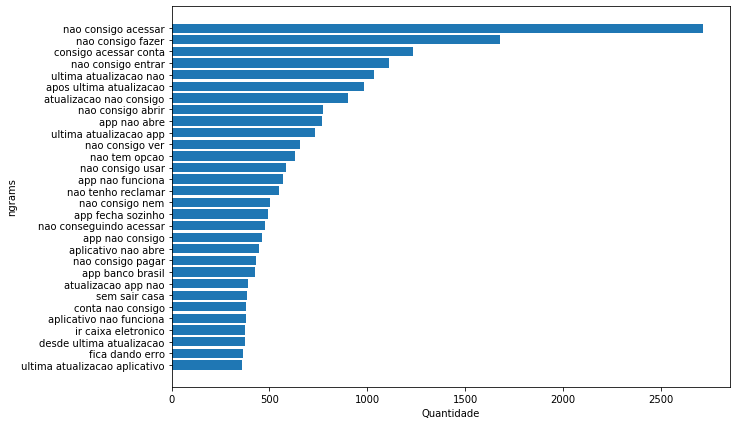

In [18]:
plt.figure(figsize=(10,7))
plt.barh(list(trigrams.keys()), trigrams.values(), align='center')
plt.xlabel('Quantidade')
plt.ylabel('ngrams')
plt.gca().invert_yaxis()